# Global Monsoon pattern

In this tutorial we show how the Global Monsoon index as it is defined by Wang et al. 2008 is derived.

In [7]:
import numpy as np
import geoutils.plotting.plots as gplt
import geoutils.geodata.base_dataset as bds
import geoutils.utils.time_utils as tu
import geoutils.tsa.time_series_analysis as tsa
import geoutils.tsa.propagation as prop
import geoutils.tsa.pca.eof as eof
import geoutils.tsa.pca.multivariate_pca as mvpca
import geoutils.utils.general_utils as gut
from importlib import reload

plot_dir = "/home/strnad/data/plots/tutorials/global_monsoon/"
data_dir = "/home/strnad/data/"

In [17]:
# Load the dataset
grid_step = 2.5
dataset_file = data_dir + \
    f"climate_data/{grid_step}/mswep_pr_{grid_step}_ds.nc"

lon_range_cut = [-180, 180]
lat_range_cut = [-50, 50]

ds_pr = bds.BaseDataset(data_nc=dataset_file,
                        can=True,
                        an_types=['dayofyear', 'month', 'JJAS'],
                        lon_range=lon_range_cut,
                        lat_range=lat_range_cut,
                        verbose=False,
                        )

Load data from in time range (numpy.datetime64('1979-01-02'), numpy.datetime64('2020-12-30'))!
Created dayofyearly anomalies!
Rename pr to pr_an_dayofyear!
Created monthly anomalies!
Rename pr to pr_an_month!
Created JJASly anomalies!
Rename pr to pr_an_JJAS!


Now we perform an EOF analysis of the precipitation field

Univariate PCA var with dataarray
Explained variance: 0.592379629611969


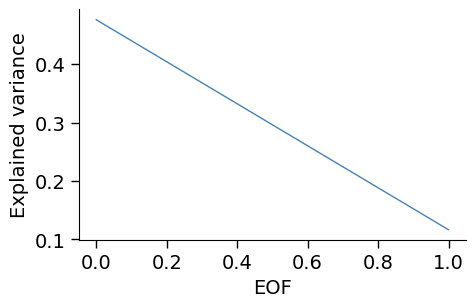

In [59]:
reload(tu)
n_components = 2
input_data = ds_pr.ds['pr']
# input_data is the 12 month climatology
# This create a time series of the mean precipitation in the region per month/day
timemean='dayofyear'
yearly_mean_pr = tu.compute_timemean(input_data,
                                     timemean=timemean,
                                     groupby=True,
                                     reset_time=True, # important for EOF labeling
                                     )

reload(eof)
reload(mvpca)
sppca = mvpca.MultivariatePCA(yearly_mean_pr, n_components=n_components)
eofs = sppca.get_eofs()
pcs = sppca.get_principal_components()
gut.myprint(f"Explained variance: {np.sum(sppca.explained_variance())}")
im = gplt.plot_xy(y_arr=sppca.explained_variance(),
                 xlabel='EOF', ylabel='Explained variance',
                 ylog=False, figsize=(5, 3))

Now plot the EOF and their corresponding PC time series.

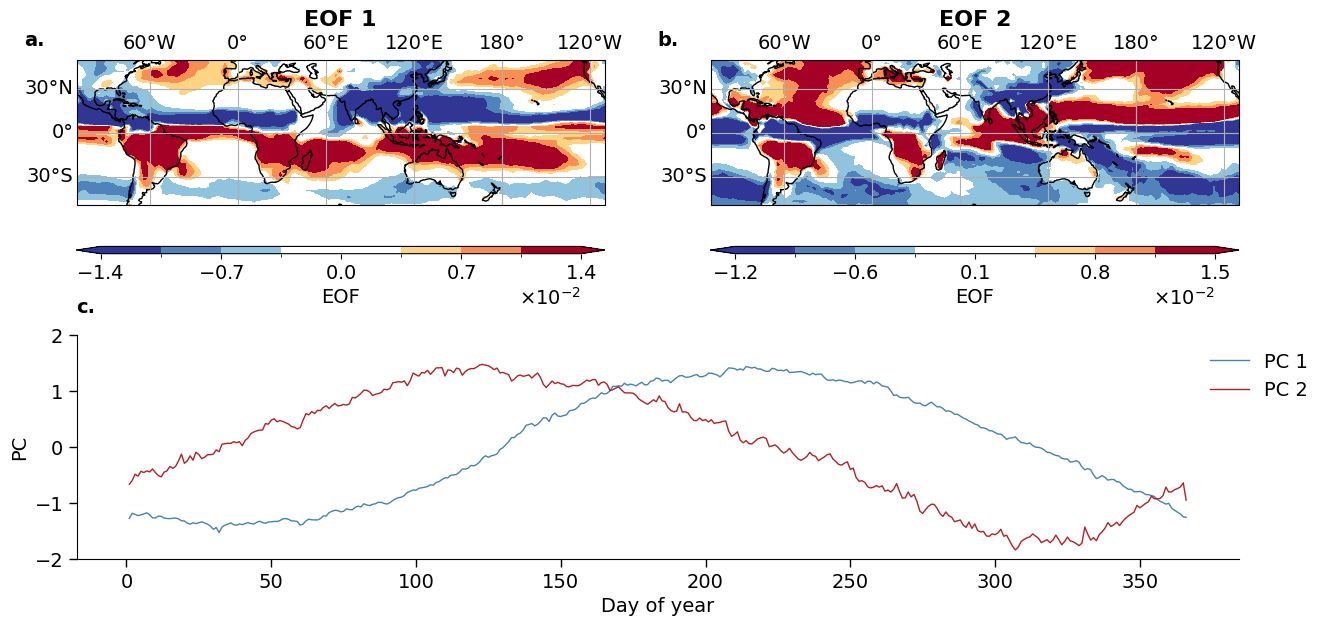

In [70]:
# EOF maps
reload(gut)
nrows = 1
ncols = n_components
im = gplt.create_multi_plot(nrows=2, ncols=ncols,
                            hspace=0.4,
                            wspace=0.2,
                            full_length_row=True,
                            figsize=(15, 7),
                            proj_arr=['PlateCarree',
                                      'PlateCarree', None],
                            end_idx=3,
                            central_longitude=70,
                            )
for i in range(sppca.n_components):
    comp = eofs.isel(eof=i)
    im_eof = gplt.plot_map(comp,
                            ax=im['ax'][i],
                            #   vmin=-.03, vmax=.03,
                            cmap='RdYlBu_r',
                            title=f'EOF {i+1}',
                            centercolor='white',
                            label='EOF',
                            )


# Now we plot the PCs
pcs = sppca.get_principal_components()
for i in range(sppca.n_components):
    gplt.plot_xy(
        ax=im['ax'][2],
        x_arr=[pcs['time']],
        y_arr=[-1*pcs.sel(eof=i)],
        xlabel='Day of year',
        ylabel=f'PC',
        figsize=(6, 3),
        color=gplt.colors[i],
        label_arr=[f'PC {i+1}'],
        loc='outside',
        ylim=[-2, 2],
        set_axis=True,
        )
savepath = plot_dir +\
f"/gm_eofs.png"
gplt.save_fig(savepath, fig=im['fig'])